In [1]:
# !python /Users/kit/Documents/Phys_Working/LLM_SR/check_path.py

# import sys
# print("\nAdding project directory to Python path...")
# sys.path.insert(0, '/Users/kit/Documents/Phys_Working/LLM_SR')
# print(f"  - Added: {sys.path[0]}")

import llmlex
import openai

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

In [2]:

api_key = os.getenv("OPENROUTER_API_KEY") if os.getenv("OPENROUTER_API_KEY") else "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"
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=api_key,
)

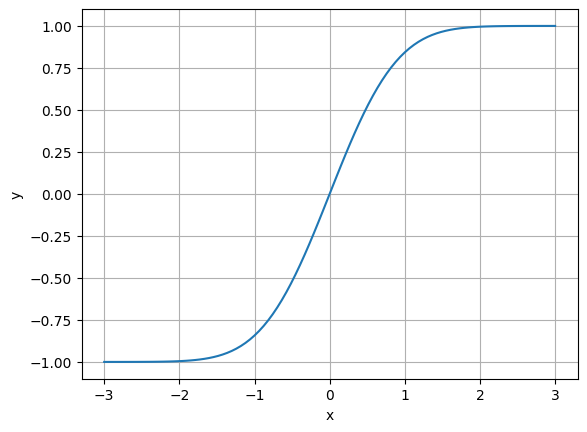

In [3]:
x = np.linspace(-3, 3, 100)
y = special.erf(x) 
#y = np.pi*np.ones(100)

plt.plot(x, y,label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
#plt.legend()
plt.savefig('plot.png')

# Getting the Base64 string
base64_image = llmlex.images.encode_image('plot.png')

In [4]:
my_imports = ["import numpy as np", "from scipy import special"]

sys_prompt = system_prompt = ("You are a symbolic regression expert. Analyze the data in the image and provide an improved mathematical ansatz. "
                         "Respond with ONLY the ansatz formula, without any explanation or commentary. Ensure it is in valid python. "
                         "You may use numpy functions, and scipy.special. "
                         "params is a list of parameters that can be of any length or complexity. "
                        )

In [5]:
r = llmlex.single_call(client, base64_image, x, y, model="openai/gpt-4o",function_list=None, system_prompt=sys_prompt,imports=my_imports)
print(r)

2025-04-10 10:44:41,486 - llmlex.llmlex - INFO - Extracted ansatz: params[0] * special.tanh(params[1] * x) with 2 parameters
Exception in fit_curve_with_guess: module 'scipy.special' has no attribute 'tanh', all params passed: (100,), (100,), <function <lambda> at 0x15405b600>, [1. 1.],<function <lambda> at 0x15405b600>, True, True, API Call Statistics:
  Successful calls (end-to-end): 0
  Failed calls: 0
  Success rate: 0.00%

Breakdown by processing stage:
  Api Call: 1 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 1 succeeded, 0 failed (100.00% success)
  Function Conversion: 1 succeeded, 0 failed (100.00% success)

Error types:
  No errors
2025-04-10 10:44:41,729 - llmlex.llmlex - INFO - Fit result: score=-inf, params=[1. 1.]


{'params': array([1., 1.]), 'score': -inf, 'ansatz': 'params[0] * special.tanh(params[1] * x)', 'Num_params': 2, 'response': ChatCompletion(id='gen-1744296280-My3daSeSGBiWz4sOL2JS', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```python\nparams[0] * special.tanh(params[1] * x)\n```', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None, reasoning=None), native_finish_reason='stop')], created=1744296280, model='openai/gpt-4o', object='chat.completion', service_tier=None, system_fingerprint='fp_b7faba9ef5', usage=CompletionUsage(completion_tokens=20, prompt_tokens=539, total_tokens=559, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None), prompt_tokens_details=PromptTokensDetails(audio_tokens=None, cached_tokens=0)), provider='OpenAI'), 'prompt': 'import numpy as np\nfrom scipy import special\ncurve_0 = l

In [6]:
population_size = 25
num_of_generations = 10
start = llmlex.llm.check_key_limit(client)
res = llmlex.run_genetic(client, base64_image, x, y, population_size,num_of_generations, 
                        temperature=1., model="openai/gpt-4o", system_prompt=sys_prompt, imports=my_imports,  elite=True, use_async=True, exit_condition=1e-5)
print(f"Credits spent: {start - llmlex.llm.check_key_limit(client)}")

/Users/trharvey/llm/lib/python3.13/site-packages/llmlex/llmlex.py:558: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(curve, x, y, p0=[1.0])
2025-04-10 10:44:42,501 - llmlex.llmlex - INFO - Constant function is not a good fit: Score: -0.7866860628128052, for constant: [5.55111512e-16]
2025-04-10 10:44:42,501 - llmlex.llmlex - INFO - Generating initial population asynchronously
2025-04-10 10:44:50,092 - llmlex.llmlex - INFO - Generated 25 individuals
2025-04-10 10:44:50,093 - llmlex.llmlex - INFO - Initial population best: score=-8.59599094837904e-05, params=[1.01261274e+00 1.16985672e+00 1.10899898e-07], ansatz: params[0] * (np.tanh(params[1] * x) + params[2])...
2025-04-10 10:44:50,095 - llmlex.llmlex - INFO - Generation 1/9: Generating 25 new individuals. Elitism? True
2025-04-10 10:44:53,270 - llmlex.llmlex - WARNING - Ansatz extraction failed: No parameters found in ansatz: 'I'm sorry, I can't assist with that.'
2025-04-10 10:44:54,070 


API Call Statistics:
  Successful calls (end-to-end): 49
  Failed calls: 2
  Success rate: 96.08%

Breakdown by processing stage:
  Api Call: 51 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 49 succeeded, 2 failed (96.08% success)
  Function Conversion: 49 succeeded, 0 failed (100.00% success)
  Curve Fitting: 49 succeeded, 0 failed (100.00% success)

Error types:
  Extraction Errors:
    - llm refusal: 2

Fitting warnings:
  - covariance estimation: 4
Credits spent: 0.0


In [7]:
len(res[0])

25

In [8]:
highest_score_element = max((item for sublist in res for item in sublist), key=lambda item: item['score'])
print(highest_score_element['ansatz'])

params[0] * special.erf(params[1] * x) + params[2]


In [9]:
print(highest_score_element['function_list'])

[('params[0] * np.tanh(params[1] * x)', array([1.01261245, 1.16985842])), ('params[0] * np.tanh(params[1] * x)', array([1.01261245, 1.16985842]))]


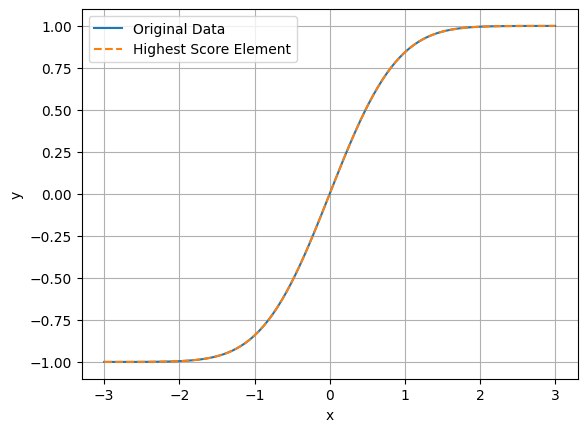

In [10]:
# Extract the parameters and the ansatz function from the highest_score_element
params = highest_score_element['params']
ansatz = highest_score_element['ansatz']

# Define the ansatz function
def ansatz_function(x, params):
    return eval(ansatz)

# Plot the original data
plt.plot(x, y, label='Original Data')

# Plot the highest score element
plt.plot(x, ansatz_function(x, params), label='Highest Score Element', linestyle='--')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

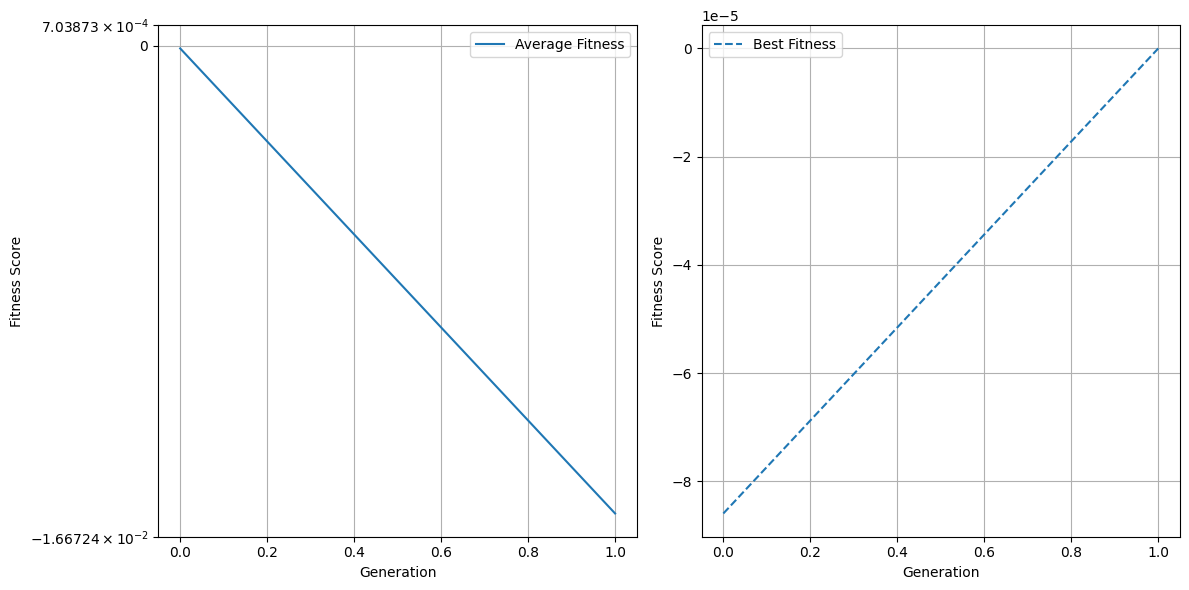

In [11]:
# Remove infinite scores
filtered_res = [[ind for ind in generation if np.isfinite(ind['score'])] for generation in res]

# Extract fitness scores from the filtered results
average_fitness = [np.mean([ind['score'] for ind in generation]) for generation in filtered_res]
best_fitness = [max([ind['score'] for ind in generation]) for generation in filtered_res]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the average fitness
axs[0].plot(range(len(average_fitness)), average_fitness, label='Average Fitness')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Fitness Score')
axs[0].set_yscale('symlog')
axs[0].legend()
axs[0].grid(True)

# Plot the best fitness
axs[1].plot(range(len(average_fitness)), best_fitness, label='Best Fitness', linestyle='--')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Fitness Score')
axs[1].legend()
axs[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()